Feature Exploration and Reduction based on: https://towardsdatascience.com/another-twitter-sentiment-analysis-with-python-part-8-dimensionality-reduction-chi2-pca-c6d06fb3fcf3

In [1]:
!pip install auto-sklearn &> /dev/null
!pip uninstall -y scipy &> /dev/null
!pip install scipy==1.7.3 &> /dev/null
!pip install xlrd==2.0.0 &> /dev/null
# !pip install https://github.com/explosion/spacy-models/releases/download/de_core_news_lg-3.3.0/de_core_news_lg-3.3.0.tar.gz &> /dev/null

In [1]:
import pandas as pd
import numpy as np
import re
import spacy
from tqdm import tqdm
from datetime import datetime
import sklearn.metrics
import matplotlib.pyplot as plt
import random
from random import sample
import nltk
from nltk.corpus import stopwords
from sklearn.base import TransformerMixin
import pickle
import autosklearn.classification
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import roc_auc_score, accuracy_score
import glob
from sklearn.feature_selection import SelectPercentile, f_classif, SelectKBest, chi2
from sklearn.pipeline import Pipeline
from time import time
from sklearn.linear_model import LogisticRegression

rng = np.random.default_rng(4711)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
commentsDF = pd.DataFrame(columns={'ID'})
for file in glob.glob("/content/drive/MyDrive/MA/Daten/*"):
     tempDF = pd.read_excel(file)
     commentsDF = pd.concat([commentsDF, tempDF], join='outer')

commentsDF = commentsDF.drop(columns=['ID', 'Active', 'CID', 'Sperrhinweis', 'Loginname'],axis=1)

commentsDF['Date'] =  pd.to_datetime(commentsDF['Date'], format='%Y-%m-%d %H:%M:%S')
commentsDF['Time'] = pd.to_datetime(commentsDF['Date']).dt.time
commentsDF['Date'] = pd.to_datetime(commentsDF['Date']).dt.date
commentsDF['Date'] = pd.to_datetime(commentsDF['Date'], format='%Y-%m-%d')


commentsDF['Text'] = commentsDF['Text'].astype(str)
commentsDF['Title'] = commentsDF['Title'].astype(str)

commentsDF = commentsDF.drop_duplicates(subset=['Text']) 
commentsDF = commentsDF.sort_values(by=['Date']).reset_index(drop=True)

In [4]:
dateRange = pd.period_range(start='2018-11-01', end='2020-06-01', freq='M')
timeSampledDF = pd.DataFrame(columns={'ID'})


for i in range(len(dateRange)):
  month = dateRange[i].month
  year = dateRange[i].year
  monthData = commentsDF[(commentsDF.Date.dt.month == dateRange[i].month) & (commentsDF.Date.dt.year == dateRange[i].year)]
  countMinor = len(monthData[monthData.Abgelehnt == 1])
  if countMinor < 1000:
    countMinor = 1000
  minorityDF = monthData[monthData.Abgelehnt == 1]
  majorityDF = monthData[monthData.Abgelehnt == 0].sample(axis='index', 
                                                          n=countMinor, 
                                                          random_state=4711,)
  timeSampledDF = pd.concat([timeSampledDF, majorityDF], join='outer')
  timeSampledDF = pd.concat([timeSampledDF, minorityDF], join='outer')

y_vals = commentsDF['Abgelehnt'].values
y_vals = y_vals.astype(int)

commentsDF['index1'] = commentsDF.index
timeSampledDF['index1'] = timeSampledDF.index

commentsDF['Mask'] = commentsDF.index1.apply(lambda x: 1 if x in timeSampledDF.index1 else 0)
mask = np.array(commentsDF['Mask']).astype('bool')

In [5]:
german_stop_words_import = open ("/content/drive/MyDrive/MA/stopwords-de.csv", "r", encoding="utf-8")
german_stop_words = pd.read_csv(german_stop_words_import, names=['stopwords'])['stopwords'].to_list()


vectorizer = TfidfVectorizer(stop_words=german_stop_words, 
                             ngram_range=(1,2), min_df = 5)
tfidf_pickle = open ("/content/drive/MyDrive/MA/preprocessor_RP_Comments_noDupes.pk", "rb")
tfidf_load = pickle.load(tfidf_pickle)

tfidf = vectorizer.fit_transform(tfidf_load)

In [6]:
tfidf_reduced = tfidf[mask]

In [8]:
y_vals = timeSampledDF['Abgelehnt'].values

train_batch = timeSampledDF.Date < "2019-11-01"

X_train = tfidf_reduced[train_batch]
Y_train = y_vals[train_batch]

test = timeSampledDF['Date'] >= "2019-11-01"
X_test = tfidf_reduced[test]
Y_test = y_vals[test]

In [9]:
x = timeSampledDF.Text
y = timeSampledDF.Abgelehnt

from sklearn.model_selection import train_test_split
SEED = 2000
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.037, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

# Feature Evaluation with up to 10k Features

In [14]:
cvec = CountVectorizer()
tvec = TfidfVectorizer()
lr = LogisticRegression(max_iter=100)
n_features = np.arange(3000,4001,3000)
classifier = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=300,
    n_jobs=-1,
    metric = autosklearn.metrics.f1
)
result = []

for n in tqdm(n_features):
  
  tvec.set_params(stop_words=german_stop_words, max_features=n, ngram_range=(1,2))
  checker_pipeline = Pipeline([
  ('vectorizer', tvec),
  ('classifier', classifier)
  ])
  if (float(((x_test[y_test == 0]).shape[0]) / float((x_test*1).shape[0])) > 0.5):
        null_accuracy = ((float(x_test[y_test == 0].shape[0])) / float((x_test).shape[0]))
  else:
      null_accuracy = float(1 - float((x_test[y_test == 0]).shape[0]) / float((x_test).shape[0]))
  t0 = time()
  sentiment_fit = checker_pipeline.fit(x_train, y_train)
  y_pred = sentiment_fit.predict(x_test)
  train_test_time = time() - t0
  accuracy = accuracy_score(y_test, y_pred)
  print("\n")
  print("Validation result for {} features".format(n))
  print("null accuracy: {0:.2f}%".format(null_accuracy*100))
  print("accuracy score: {0:.2f}%".format(accuracy*100))
  if accuracy > null_accuracy:
      print("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
  elif accuracy == null_accuracy:
      print("model has the same accuracy with the null accuracy")
  else:
      print("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
  print( "train and test time: {0:.2f}s".format(train_test_time))
  print( "-"*80)
  nfeature_accuracy = accuracy
  tt_time = train_test_time
  result.append((n,nfeature_accuracy,tt_time))

100%|██████████| 1/1 [05:06<00:00, 306.94s/it]



Validation result for 3000 features
null accuracy: 57.06%
accuracy score: 68.12%
model is 11.06% more accurate than null accuracy
train and test time: 306.93s
--------------------------------------------------------------------------------


In [ ]:
ch2_result = []

tvec = TfidfVectorizer(stop_words=german_stop_words,
                       max_features=100000,ngram_range=(1, 2))
x_train_tfidf = tvec.fit_transform(x_train)
x_validation_tfidf = tvec.transform(x_validation)

chi2score = chi2(x_train_tfidf, y_train)[0]

Text(0.5, 0, '$\\chi^2$')

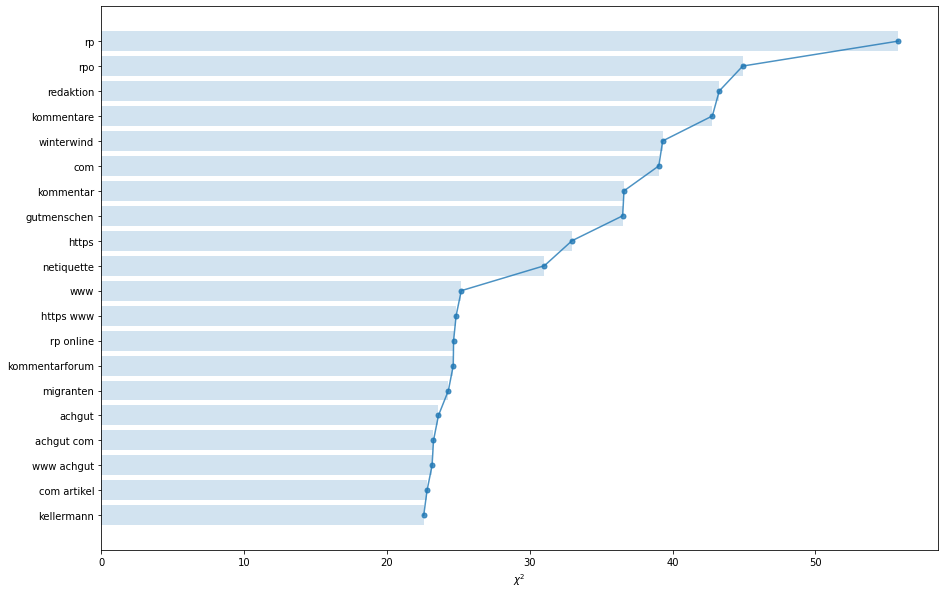

In [ ]:
plt.figure(figsize=(15,10))
wscores = zip(tvec.get_feature_names(), chi2score)
wchi2 = sorted(wscores, key=lambda x:x[1])
topchi2 = list(zip(*wchi2[-20:]))
x = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x,topchi2[1], align='center', alpha=0.2)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')

In [ ]:
ch2_result = []

tvec = TfidfVectorizer(stop_words=german_stop_words,
                       max_features=10000,ngram_range=(1, 2))
x_train_tfidf = tvec.fit_transform(x_train)
x_validation_tfidf = tvec.transform(x_validation)

chi2score = chi2(x_train_tfidf, y_train)[0]

In [ ]:
for n in np.arange(1000,10000,1000):
    ch2 = SelectKBest(chi2, k=n)
    x_train_chi2_selected = ch2.fit_transform(x_train_tfidf, y_train)
    x_validation_chi2_selected = ch2.transform(x_validation_tfidf)
    clf = LogisticRegression(max_iter=1000)
    clf.fit(x_train_chi2_selected, y_train)
    score = clf.score(x_validation_chi2_selected, y_validation)
    ch2_result.append(score)
    print("chi2 feature selection evaluation calculated for {} features".format(n))

chi2 feature selection evaluation calculated for 1000 features
chi2 feature selection evaluation calculated for 2000 features
chi2 feature selection evaluation calculated for 3000 features
chi2 feature selection evaluation calculated for 4000 features
chi2 feature selection evaluation calculated for 5000 features
chi2 feature selection evaluation calculated for 6000 features
chi2 feature selection evaluation calculated for 7000 features
chi2 feature selection evaluation calculated for 8000 features
chi2 feature selection evaluation calculated for 9000 features


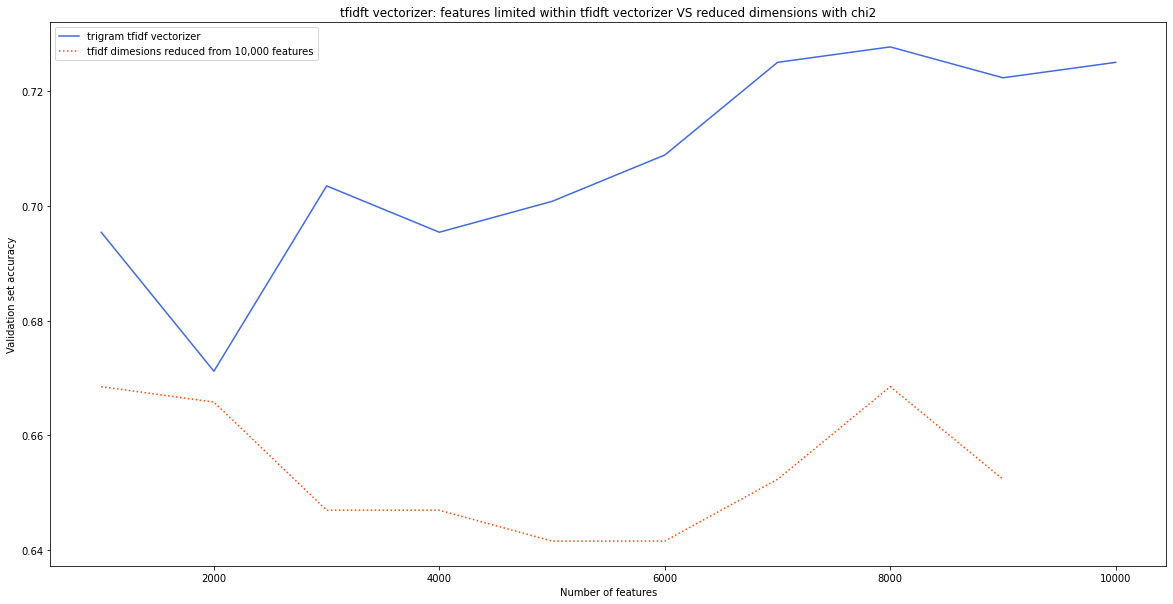

In [ ]:
nfeatures_plot_tgt = pd.DataFrame(result,columns=['nfeatures','validation_accuracy','train_test_time'])

plt.figure(figsize=(20,10))
plt.plot(nfeatures_plot_tgt.nfeatures, nfeatures_plot_tgt.validation_accuracy,label='trigram tfidf vectorizer',color='royalblue')
plt.plot(np.arange(1000,10000,1000), ch2_result,label='tfidf dimesions reduced from 10,000 features',linestyle=':', color='orangered')

plt.title("tfidft vectorizer: features limited within tfidft vectorizer VS reduced dimensions with chi2")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

# Evaluation of Features with up to 100k

In [ ]:
cvec = CountVectorizer()
tvec = TfidfVectorizer()
lr = LogisticRegression(max_iter=1000)
n_features = np.arange(10000,100001,10000)
classifier = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=60,
    n_jobs=-1,
    metric = autosklearn.metrics.f1
)
selector = SelectKBest()
result100k = []

for n in tqdm(n_features):
  
  tvec.set_params(stop_words=german_stop_words, max_features=n, ngram_range=(1,2))
  selector.set_params(k=n)
  checker_pipeline = Pipeline([
  ('vectorizer', tvec),
  ('select', selector),
  ('classifier', classifier)
  ])
  if (float(((x_test[y_test == 0]).shape[0]) / float((x_test*1).shape[0])) > 0.5):
        null_accuracy = ((float(x_test[y_test == 0].shape[0])) / float((x_test).shape[0]))
  else:
      null_accuracy = float(1 - float((x_test[y_test == 0]).shape[0]) / float((x_test).shape[0]))
  t0 = time()
  sentiment_fit = checker_pipeline.fit(x_train, y_train)
  y_pred = sentiment_fit.predict(x_test)
  train_test_time = time() - t0
  accuracy = accuracy_score(y_test, y_pred)
  print("\n")
  print("Validation result for {} features".format(n))
  print("null accuracy: {0:.2f}%".format(null_accuracy*100))
  print("accuracy score: {0:.2f}%".format(accuracy*100))
  if accuracy > null_accuracy:
      print("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
  elif accuracy == null_accuracy:
      print("model has the same accuracy with the null accuracy")
  else:
      print("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
  print( "train and test time: {0:.2f}s".format(train_test_time))
  print( "-"*80)
  nfeature_accuracy = accuracy
  tt_time = train_test_time
  result100k.append((n,nfeature_accuracy,tt_time))

 10%|█         | 1/10 [00:11<01:43, 11.50s/it]



Validation result for 10000 features
null accuracy: 56.33%
accuracy score: 72.51%
model is 16.17% more accurate than null accuracy
train and test time: 11.49s
--------------------------------------------------------------------------------


 20%|██        | 2/10 [00:26<01:47, 13.46s/it]



Validation result for 20000 features
null accuracy: 56.33%
accuracy score: 74.39%
model is 18.06% more accurate than null accuracy
train and test time: 14.68s
--------------------------------------------------------------------------------


 30%|███       | 3/10 [00:39<01:32, 13.27s/it]



Validation result for 30000 features
null accuracy: 56.33%
accuracy score: 74.12%
model is 17.79% more accurate than null accuracy
train and test time: 13.03s
--------------------------------------------------------------------------------


 40%|████      | 4/10 [00:50<01:14, 12.49s/it]



Validation result for 40000 features
null accuracy: 56.33%
accuracy score: 72.51%
model is 16.17% more accurate than null accuracy
train and test time: 11.28s
--------------------------------------------------------------------------------


 50%|█████     | 5/10 [01:02<01:01, 12.28s/it]



Validation result for 50000 features
null accuracy: 56.33%
accuracy score: 73.05%
model is 16.71% more accurate than null accuracy
train and test time: 11.90s
--------------------------------------------------------------------------------


 60%|██████    | 6/10 [01:12<00:45, 11.49s/it]



Validation result for 60000 features
null accuracy: 56.33%
accuracy score: 73.05%
model is 16.71% more accurate than null accuracy
train and test time: 9.95s
--------------------------------------------------------------------------------


 70%|███████   | 7/10 [01:25<00:35, 11.88s/it]



Validation result for 70000 features
null accuracy: 56.33%
accuracy score: 73.05%
model is 16.71% more accurate than null accuracy
train and test time: 12.66s
--------------------------------------------------------------------------------


 80%|████████  | 8/10 [01:37<00:23, 11.88s/it]



Validation result for 80000 features
null accuracy: 56.33%
accuracy score: 73.32%
model is 16.98% more accurate than null accuracy
train and test time: 11.88s
--------------------------------------------------------------------------------


 90%|█████████ | 9/10 [01:50<00:12, 12.33s/it]



Validation result for 90000 features
null accuracy: 56.33%
accuracy score: 73.32%
model is 16.98% more accurate than null accuracy
train and test time: 13.29s
--------------------------------------------------------------------------------


100%|██████████| 10/10 [02:03<00:00, 12.30s/it]



Validation result for 100000 features
null accuracy: 56.33%
accuracy score: 73.05%
model is 16.71% more accurate than null accuracy
train and test time: 12.61s
--------------------------------------------------------------------------------


In [ ]:
ch2_100k_result = []

tvec = TfidfVectorizer(stop_words=german_stop_words,
                       max_features=100000,ngram_range=(1, 2))
x_train_tfidf = tvec.fit_transform(x_train)
x_validation_tfidf = tvec.transform(x_validation)

chi2score_100k = chi2(x_train_tfidf, y_train)[0]

In [ ]:
for n in np.arange(10000,100000,10000):
    ch2 = SelectKBest(chi2, k=n)
    x_train_chi2_selected = ch2.fit_transform(x_train_tfidf, y_train)
    x_validation_chi2_selected = ch2.transform(x_validation_tfidf)
    clf = LogisticRegression(max_iter=1000)
    clf.fit(x_train_chi2_selected, y_train)
    score = clf.score(x_validation_chi2_selected, y_validation)
    ch2_100k_result.append(score)
    print("chi2 feature selection evaluation calculated for {} features".format(n))

chi2 feature selection evaluation calculated for 10000 features
chi2 feature selection evaluation calculated for 20000 features
chi2 feature selection evaluation calculated for 30000 features
chi2 feature selection evaluation calculated for 40000 features
chi2 feature selection evaluation calculated for 50000 features
chi2 feature selection evaluation calculated for 60000 features
chi2 feature selection evaluation calculated for 70000 features
chi2 feature selection evaluation calculated for 80000 features
chi2 feature selection evaluation calculated for 90000 features


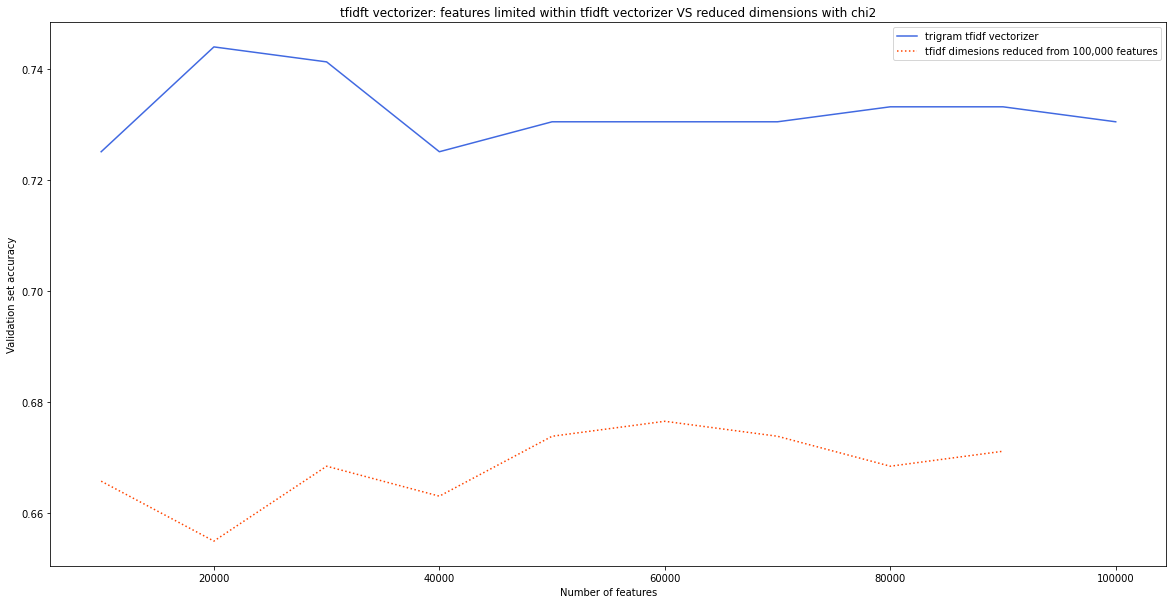

In [ ]:
nfeatures_plot_tgt = pd.DataFrame(result100k,columns=['nfeatures','validation_accuracy','train_test_time'])

plt.figure(figsize=(20,10))
plt.plot(nfeatures_plot_tgt.nfeatures, nfeatures_plot_tgt.validation_accuracy,label='trigram tfidf vectorizer',color='royalblue')
plt.plot(np.arange(10000,100000,10000), ch2_100k_result,label='tfidf dimesions reduced from 100,000 features',linestyle=':', color='orangered')

plt.title("tfidft vectorizer: features limited within tfidft vectorizer VS reduced dimensions with chi2")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()